<a href="https://colab.research.google.com/github/orangegreen212/Customer-Segmentation-and-Revenue-Forecasting/blob/main/Customer_Segmentation_Story.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Customer Value: A Data-Driven Segmentation Story

### Project Goal, Dataset Description, and KPIs

**Project Goal:** To segment the customer base of an online retail store into distinct, actionable groups to enable targeted and effective marketing strategies.

**Dataset Description:**
*   **Source:** [Kaggle E-commerce Dataset](https://www.kaggle.com/datasets/carrie1/ecommerce-data).
*   **Content:** This is a transactional dataset containing all transactions occurring between 01/12/2010 and 09/12/2011 for a UK-based and registered non-store online retail.
*   **Size:** The original dataset contains 541,909 records and 8 columns.
*   **Key Columns:**
    *   `InvoiceNo`: A unique identifier for each transaction. Invoices starting with 'C' denote cancellations.
    *   `StockCode`: Product (item) code.
    *   `Quantity`: The quantity of each product per transaction.
    *   `InvoiceDate`: The date and time of the transaction.
    *   `UnitPrice`: The price of a single unit of the product in Sterling (£).
    *   `CustomerID`: A unique identifier for each customer.

**Key Performance Indicators (KPIs) & Success Metrics:**
To evaluate customer behavior and the health of the business, we will focus on the following metrics:
1.  **Average Order Value (AOV):** To understand the average transaction size.
2.  **Customer Lifetime Value (CLV):** To measure the total net revenue an average customer generates.
3.  **Churn Rate:** To identify the percentage of customers who have become inactive.
4.  **Customer Segmentation Distribution:** To measure the proportion of customers in each value tier (e.g., Champions, At-Risk). Success will be measured by our ability to create distinct and interpretable customer segments.

### Step 1: Setting the Scene - Data Loading & Initial Exploration

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# The notebook was originally run in Google Colab, so we mount the drive first.
from google.colab import drive
drive.mount('/content/drive')

df = pd.read_csv('/content/drive/MyDrive/Data for GC/Customer Analysis/Project RFM and Cluster Analysis/data.csv', encoding='latin-1')


print(f"Original data shape: {df.shape}")
print("\nData columns:")
print(df.columns.tolist())
print("\nData info:")
df.info()

print("\nData sample:")
df.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Original data shape: (541909, 8)

Data columns:
['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate', 'UnitPrice', 'CustomerID', 'Country']

Data info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB

Data sample:


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


**Initial Observations:**
- The dataset contains over 540,000 transactional records.
- Key columns include `CustomerID`, `InvoiceNo`, `InvoiceDate`, `Quantity`, and `UnitPrice`.
- `CustomerID` has null values, which we'll need to handle as we can't analyze anonymous transactions at a customer level.
- `InvoiceDate` is an object type and needs to be converted to a proper datetime format.

### Step 2: Data Preparation - Forging Raw Data into a Usable Asset

Before any analysis can begin, we must clean and prepare the data. This foundational step ensures our metrics and segments are accurate and reliable.

Our key preparation tasks are:
1.  **Remove records without a `CustomerID`**, as our analysis is customer-centric.
2.  **Convert `InvoiceDate`** to a datetime format for time-based calculations (like Recency).
3.  **Handle returns:** `InvoiceNo` values starting with 'C' indicate cancellations, and `Quantity` is negative. We'll keep these records to calculate a true *net* monetary value.
4.  **Create a `TotalPrice` column**, which is the product of `Quantity` and `UnitPrice`. This will be positive for purchases and negative for returns.

In [ ]:
# Remove rows without a CustomerID, as they are not useful for this analysis.
df_clean = df.dropna(subset=['CustomerID']).copy()

# Convert CustomerID to integer for cleaner representation.
df_clean['CustomerID'] = df_clean['CustomerID'].astype(int)

# Convert InvoiceDate to datetime format. 'errors=coerce' will turn any parsing errors into NaT (Not a Time).
df_clean['InvoiceDate'] = pd.to_datetime(df_clean['InvoiceDate'], errors='coerce')

# Create the TotalPrice column. This is a crucial step.
# This column will have POSITIVE values for purchases and NEGATIVE values for returns.
df_clean['TotalPrice'] = df_clean['Quantity'] * df_clean['UnitPrice']

# Remove transactions with a negative UnitPrice, which are likely data errors.
df_clean = df_clean[df_clean['UnitPrice'] > 0]

print("Data preparation complete.")
print(f"Shape of the prepared dataframe: {df_clean.shape}")
print(f"Date range of transactions: {df_clean['InvoiceDate'].min()} to {df_clean['InvoiceDate'].max()}")

Data preparation complete.
Shape of the prepared dataframe: (406789, 9)
Date range of transactions: 2010-12-01 08:26:00 to 2011-12-09 12:50:00


### Exploratory Data Analysis (EDA) - Getting a Feel for the Data

Before diving deep into segmentation, let's explore some high-level trends in the data. This will provide context on business performance over time and geographical distribution.

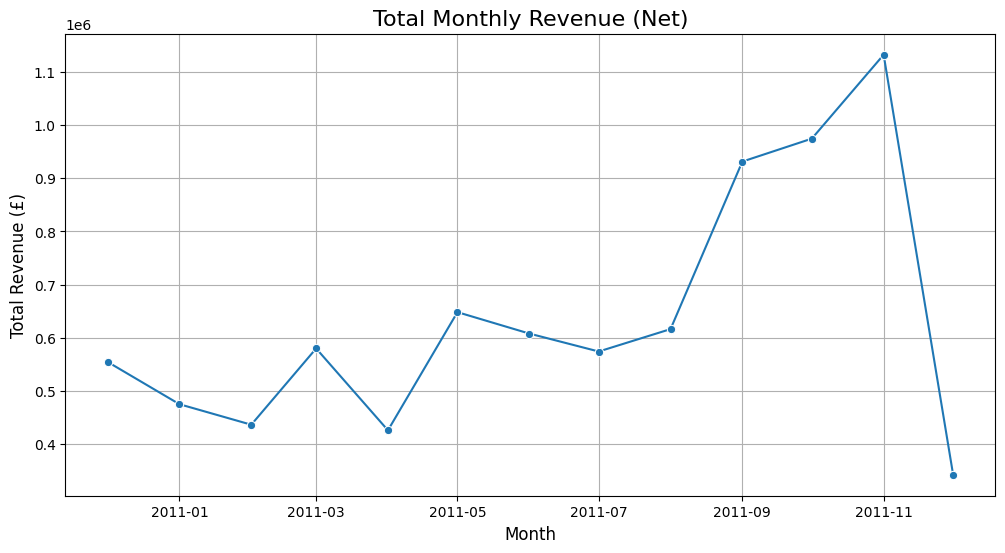

/tmp/ipython-input-966987076.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='NumberOfOrders', y='Country', data=top_countries, palette='viridis')


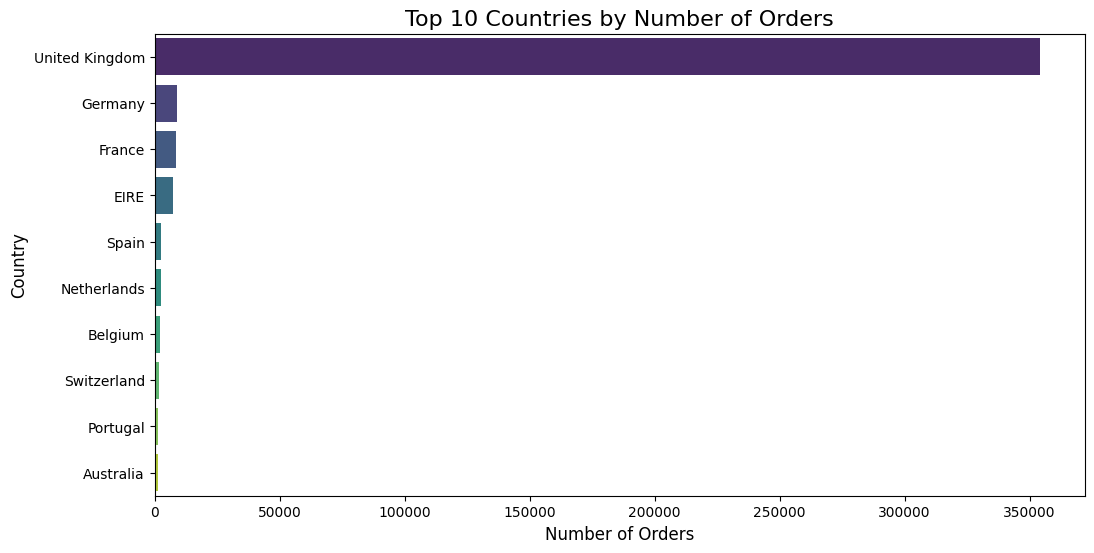

In [ ]:
# --- EDA Visualizations ---

# 1. Monthly Revenue Trend
# We need to extract the month from the InvoiceDate.
df_clean['InvoiceMonth'] = df_clean['InvoiceDate'].dt.to_period('M')
monthly_revenue = df_clean.groupby('InvoiceMonth')['TotalPrice'].sum().reset_index()
monthly_revenue['InvoiceMonth'] = monthly_revenue['InvoiceMonth'].dt.to_timestamp() # Convert back to timestamp for plotting

plt.figure(figsize=(12, 6))
sns.lineplot(x='InvoiceMonth', y='TotalPrice', data=monthly_revenue, marker='o')
plt.title('Total Monthly Revenue (Net)', fontsize=16)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Total Revenue (£)', fontsize=12)
plt.grid(True)
plt.show()

# 2. Top 10 Countries by Number of Orders
# We need to exclude returns for this analysis to count purchase orders.
purchase_orders = df_clean[df_clean['TotalPrice'] > 0]
top_countries = purchase_orders['Country'].value_counts().nlargest(10).reset_index()
top_countries.columns = ['Country', 'NumberOfOrders']

plt.figure(figsize=(12, 6))
sns.barplot(x='NumberOfOrders', y='Country', data=top_countries, palette='viridis')
plt.title('Top 10 Countries by Number of Orders', fontsize=16)
plt.xlabel('Number of Orders', fontsize=12)
plt.ylabel('Country', fontsize=12)
plt.show()

**EDA Insights:**
*   **Monthly Revenue:** The line chart shows a strong upward trend in revenue throughout the year, peaking dramatically in November. This is a classic retail pattern, indicating a significant increase in sales leading up to the holiday season. The dip in December is likely due to the dataset ending on December 9th, 2011, not capturing the full month.
*   **Geographical Distribution:** As expected, the vast majority of orders come from the United Kingdom. Germany, France, and EIRE (Ireland) are the next most significant markets, with other countries contributing a much smaller volume of orders. This confirms that the business's primary market is domestic.

### Step 3: Taking the Pulse - Key Business Metrics Analysis

With clean data, we can now calculate high-level business metrics to understand the overall health and performance of the business. We will focus on net values, which correctly account for customer returns.

#### Total Net Revenue
This is the total income from sales after accounting for returns.
$$\text{Net Revenue} = \sum(\text{Quantity} \times \text{UnitPrice})$$

In [ ]:
net_revenue = df_clean['TotalPrice'].sum()
print(f"Total Net Revenue: ${net_revenue:,.2f}")

Total Net Revenue: $8,300,065.81


#### Average Order Value (AOV)
This metric tells us the average amount a customer spends per transaction. For AOV, we only consider purchase transactions (where `TotalPrice` > 0).
$$\text{AOV} = \frac{\text{Total Revenue from Purchases}}{\text{Total Number of Purchase Orders}}$$

In [ ]:
# Filter for purchase transactions only
df_purchases = df_clean[df_clean['TotalPrice'] > 0]

# Calculate AOV
aov = df_purchases.groupby('InvoiceNo')['TotalPrice'].sum().mean()
print(f"Average Order Value (AOV): ${aov:.2f}")

Average Order Value (AOV): $480.87


#### Customer Lifetime Value (CLV) - Simplified
A simple way to estimate historical CLV is to calculate the average net revenue generated per customer. We only consider customers with a positive final net revenue.
$$\text{Average Net Revenue per Customer} = \frac{\sum(\text{Customer Net Revenue})}{\text{Total Number of Customers with Positive Revenue}}$$

In [ ]:
# Calculate customer-level metrics
customer_metrics = df_clean.groupby('CustomerID').agg(
    Net_Revenue=('TotalPrice', 'sum')
).reset_index()

# We only consider customers with a positive final revenue for a meaningful average
positive_revenue_customers = customer_metrics[customer_metrics['Net_Revenue'] > 0]

clv_simple = positive_revenue_customers['Net_Revenue'].mean()
print(f"Average Net Revenue per Customer (Simple CLV): ${clv_simple:.2f}")

Average Net Revenue per Customer (Simple CLV): $1923.48


#### Churn Rate Analysis
Churn is a critical metric for subscription businesses, but it's also useful in retail. We can define a customer as "churned" if they haven't made a purchase within a specific timeframe (e.g., 90 days).
$$\text{Churn Rate} = \frac{\text{Number of Churned Customers}}{\text{Total Number of Customers}}$$

In [ ]:
# Add the last purchase date to our customer metrics for churn calculation
last_purchase_dates = df_clean.groupby('CustomerID')['InvoiceDate'].max().reset_index()
last_purchase_dates.rename(columns={'InvoiceDate': 'LastPurchase'}, inplace=True)

customer_metrics = customer_metrics.merge(last_purchase_dates, on='CustomerID')

# Define a customer as "churned" if their last purchase was more than 90 days ago
# The churn date is calculated relative to the last transaction date in the dataset.
churn_threshold_date = df_clean['InvoiceDate'].max() - timedelta(days=90)

churned_customers = customer_metrics[customer_metrics['LastPurchase'] < churn_threshold_date]
active_customers = customer_metrics[customer_metrics['LastPurchase'] >= churn_threshold_date]

churn_rate = len(churned_customers) / len(customer_metrics)

print(f"Churn Analysis (90-day inactivity threshold):")
print(f"Churn Date Threshold: {churn_threshold_date.date()}")
print(f"Total Customers: {len(customer_metrics)}")
print(f"Churned Customers: {len(churned_customers)}")
print(f"Active Customers: {len(active_customers)}")
print(f"Churn Rate: {churn_rate:.2%}")

Churn Analysis (90-day inactivity threshold):
Churn Date Threshold: 2011-09-10
Total Customers: 4371
Churned Customers: 1454
Active Customers: 2917
Churn Rate: 33.26%


#### Retention Funnel Analysis (Repeat Purchase Funnel)

While we cannot build a traditional acquisition funnel (Visits -> Cart -> Purchase) with this dataset, we can analyze a **retention funnel**. This funnel shows what percentage of customers return for subsequent purchases, which is a powerful indicator of customer loyalty and product satisfaction.

The stages of our retention funnel will be:
1.  All customers who made at least one purchase.
2.  The percentage of those who returned for a second purchase.
3.  The percentage of *those* who returned for a third, and so on.

Retention Funnel Data:
   PurchaseNumber  CustomerCount  RetentionRate
0               1           4338     100.000000
1               2           2845      65.583218
2               3           2010      46.334716
3               4           1502      34.624251
4               5           1114      25.680037
5               6            872      20.101429
6               7            700      16.136468
7               8            557      12.840018
8               9            459      10.580913
9              10            391       9.013370


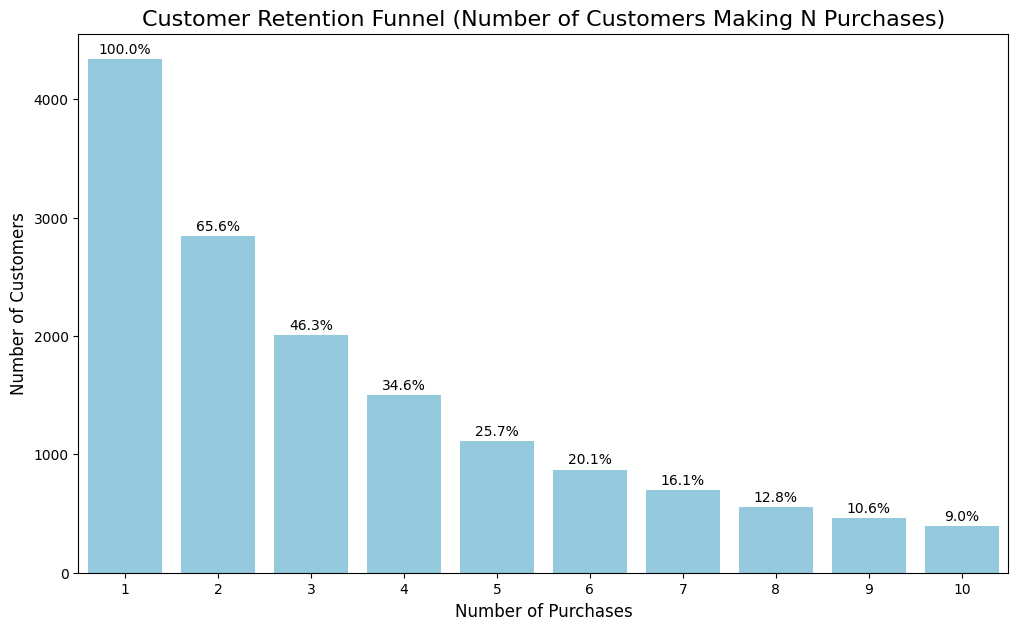

In [ ]:

# Count the number of unique orders for each customer
purchase_counts = df_clean[df_clean['TotalPrice'] > 0].groupby('CustomerID')['InvoiceNo'].nunique().reset_index()
purchase_counts.rename(columns={'InvoiceNo': 'NumberOfPurchases'}, inplace=True)

# Count how many customers made at least N purchases
max_purchases = purchase_counts['NumberOfPurchases'].max()
funnel_data = []

total_customers = len(purchase_counts)

for i in range(1, 11): # Let's analyze the funnel for the first 10 purchases
    num_customers_at_stage = purchase_counts[purchase_counts['NumberOfPurchases'] >= i].shape[0]
    if num_customers_at_stage > 0:
        retention_rate = (num_customers_at_stage / total_customers) * 100
        funnel_data.append({'PurchaseNumber': i, 'CustomerCount': num_customers_at_stage, 'RetentionRate': retention_rate})

funnel_df = pd.DataFrame(funnel_data)

print("Retention Funnel Data:")
print(funnel_df)

# --- Visualization of the Retention Funnel ---
plt.figure(figsize=(12, 7))
ax = sns.barplot(x='PurchaseNumber', y='CustomerCount', data=funnel_df, color='skyblue')
plt.title('Customer Retention Funnel (Number of Customers Making N Purchases)', fontsize=16)
plt.xlabel('Number of Purchases', fontsize=12)
plt.ylabel('Number of Customers', fontsize=12)

# Add annotations (percentage retention)
for index, row in funnel_df.iterrows():
    ax.text(row.name, row.CustomerCount + 50, f"{row.RetentionRate:.1f}%",
            color='black', ha="center")

plt.show()

#### A Note on Customer Acquisition Cost (CAC)

**Customer Acquisition Cost (CAC)** is a crucial metric that measures the total cost to acquire a new customer. The formula is:

$$ \text{CAC} = \frac{\text{Total Marketing & Sales Spend}}{\text{Number of New Customers Acquired}} $$

It is important to note that **CAC cannot be calculated from this dataset**. This is because the data lacks two key components:
1.  **Marketing Spend Data:** There is no information on the costs associated with advertising, campaigns, or other sales and marketing efforts.
2.  **New vs. Returning Customer Data:** Since the dataset covers a fixed period, we cannot definitively identify which customers are truly "new" to the business versus those who may have purchased before this period began.

**Recommendation for Future Analysis:**
To enable CAC calculation and a full profitability analysis, the business should integrate marketing expenditure data with transaction logs. By comparing CAC to Customer Lifetime Value (CLV), the business can assess the long-term profitability of its customer acquisition strategies. A healthy business model typically requires that **CLV > CAC**.

### Step 4: Customer Segmentation

Now we move to the core of our analysis: segmenting customers. We'll use two powerful techniques:
1.  **RFM Analysis:** A rule-based marketing model that segments customers based on their transaction history.
2.  **K-Means Clustering:** An unsupervised machine learning algorithm that finds natural groupings in the data.

#### Part A: The RFM Framework

RFM stands for **Recency, Frequency, and Monetary value**. It's a classic model for identifying a company's best customers.

-   **Recency (R):** How recently did the customer purchase? (Lower is better)
-   **Frequency (F):** How often do they purchase? (Higher is better)
-   **Monetary (M):** How much do they spend (net value)? (Higher is better)

In [ ]:
# Set a snapshot date for calculating recency, which is one day after the last transaction.
snapshot_date = df_clean['InvoiceDate'].max() + timedelta(days=1)

# Calculate RFM metrics for each customer
rfm_df = df_clean.groupby('CustomerID').agg({
    'InvoiceDate': lambda date: (snapshot_date - date.max()).days,  # Recency
    'InvoiceNo': lambda num: num.nunique(),                       # Frequency
    'TotalPrice': lambda price: price.sum()                        # Monetary (Net)
})

# Rename columns for clarity
rfm_df.rename(columns={'InvoiceDate': 'Recency',
                           'InvoiceNo': 'Frequency',
                           'TotalPrice': 'Monetary'},
              inplace=True)

# Clean the RFM data: remove customers with zero or negative monetary value, as they are not relevant for this segmentation.
rfm_df = rfm_df[rfm_df['Monetary'] > 0]
rfm_df = rfm_df.reset_index()

print("\nCalculated RFM metrics (first 5 customers):")
print(rfm_df.head())


Calculated RFM metrics (first 5 customers):
   CustomerID  Recency  Frequency  Monetary
0       12347        2          7   4310.00
1       12348       75          4   1797.24
2       12349       19          1   1757.55
3       12350      310          1    334.40
4       12352       36         11   1545.41


#### RFM Scoring & Segmentation

To make the RFM values comparable, we'll score each customer from 1 to 5 for each metric based on quintiles.
- A recency score of 5 means they purchased very recently.
- A frequency score of 5 means they purchase very often.
- A monetary score of 5 means they spend a lot.

We then sum these scores to get a total `RFM_Score` and assign customers to named segments.

In [ ]:
# Create scores (1-5) for each metric using quintiles. 5 is best.
# For Recency, lower values are better, so we invert the labels.
rfm_df['R_Score'] = pd.qcut(rfm_df['Recency'], 5, labels=[5, 4, 3, 2, 1])
# For Frequency and Monetary, higher values are better.
rfm_df['F_Score'] = pd.qcut(rfm_df['Frequency'].rank(method='first'), 5, labels=[1, 2, 3, 4, 5])
rfm_df['M_Score'] = pd.qcut(rfm_df['Monetary'], 5, labels=[1, 2, 3, 4, 5])

# Combine scores to get a total RFM score
rfm_df['RFM_Score'] = rfm_df['R_Score'].astype(int) + rfm_df['F_Score'].astype(int) + rfm_df['M_Score'].astype(int)

# Create human-readable segments based on the total score
def segment_customers(rfm_score):
    if rfm_score >= 12:
        return 'Champions'
    elif rfm_score >= 10:
        return 'Loyal Customers'
    elif rfm_score >= 8:
        return 'Potential Loyalists'
    elif rfm_score >= 6:
        return 'Promising'
    elif rfm_score >= 4:
        return 'Needs Attention'
    else:
        return 'At Risk'

rfm_df['Customer_Segment'] = rfm_df['RFM_Score'].apply(segment_customers)

# Display the distribution of customers across segments
segment_counts = rfm_df['Customer_Segment'].value_counts().sort_values(ascending=False)
print("\nCustomer Segment Distribution (RFM-based):")
print(segment_counts)


Customer Segment Distribution (RFM-based):
Customer_Segment
Champions              1259
Promising               815
Potential Loyalists     715
Needs Attention         683
Loyal Customers         658
At Risk                 190
Name: count, dtype: int64


/tmp/ipython-input-3151565859.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='Customer_Segment', data=rfm_df, order=order, palette="viridis")


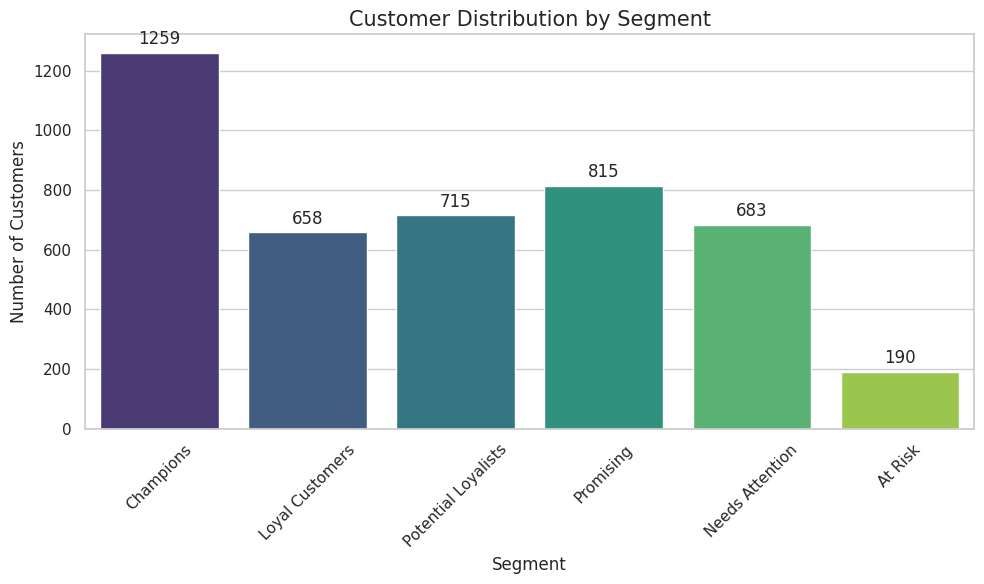

In [ ]:
# Настройка стиля
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))

# Порядок сегментов для правильного отображения (от лучших к худшим)
order = ['Champions', 'Loyal Customers', 'Potential Loyalists',
         'Promising', 'Needs Attention', 'At Risk']

# Рисуем график
ax = sns.countplot(x='Customer_Segment', data=rfm_df, order=order, palette="viridis")

# Добавляем подписи
plt.title('Customer Distribution by Segment', fontsize=15)
plt.xlabel('Segment', fontsize=12)
plt.ylabel('Number of Customers', fontsize=12)
plt.xticks(rotation=45)

# Добавляем цифры над столбцами
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.tight_layout()
plt.show()

In [ ]:
# Группируем и считаем средние значения
rfm_summary = rfm_df.groupby('Customer_Segment').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean',
    'RFM_Score': 'count' # Чтобы показать количество
}).rename(columns={'RFM_Score': 'Count'}).sort_values('Monetary', ascending=False)

# Округляем для красоты
rfm_summary = rfm_summary.round(1)

# Выводим таблицу
print(rfm_summary)

# Если хотите красиво отобразить прямо в ноутбуке (стилизация Pandas)
display(rfm_summary.style.background_gradient(cmap='YlGnBu'))

                     Recency  Frequency  Monetary  Count
Customer_Segment                                        
Champions               18.2       12.0    5107.6   1259
Loyal Customers         47.7        4.1    1240.3    658
Potential Loyalists     75.3        2.6     734.1    715
Promising              110.8        1.7     421.2    815
Needs Attention        202.3        1.2     250.8    683
At Risk                283.3        1.0     143.9    190


,Recency,Frequency,Monetary,Count
Customer_Segment,,,,
Champions,18.200000,12.000000,5107.600000,1259
Loyal Customers,47.700000,4.100000,1240.300000,658
Potential Loyalists,75.300000,2.600000,734.100000,715
Promising,110.800000,1.700000,421.200000,815
Needs Attention,202.300000,1.200000,250.800000,683
At Risk,283.300000,1.000000,143.900000,190


#### Part B: Algorithmic Segmentation with K-Means Clustering

While RFM is powerful, it relies on predefined rules. K-Means clustering is an unsupervised machine learning algorithm that can find *natural* groupings in our data without rules. It works by grouping customers with similar RFM characteristics together.

**Preprocessing for K-Means:**
1.  **Log Transformation:** RFM data is often highly skewed (e.g., a few customers buy much more than others). A log transform helps to normalize the distribution.
2.  **Standard Scaling:** K-Means is a distance-based algorithm, so features with larger scales (like Monetary) can dominate. Scaling ensures each RFM metric has equal importance.

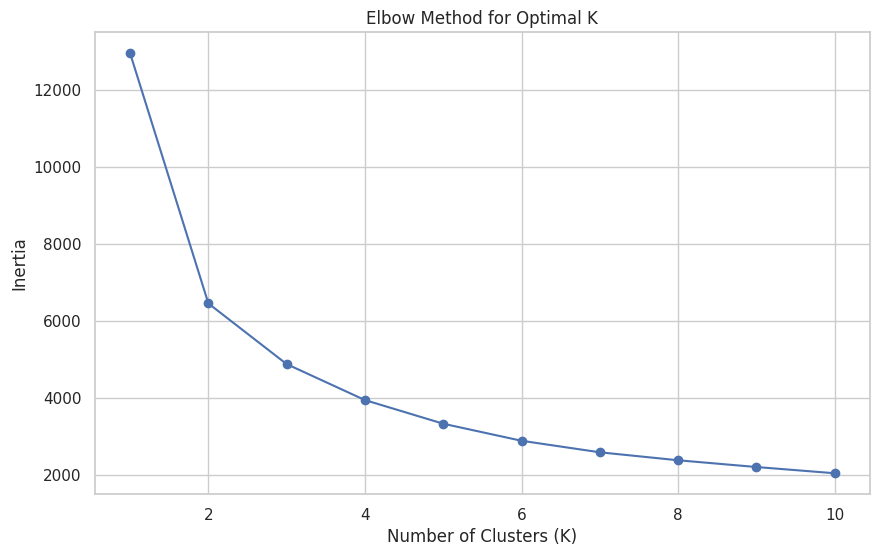

In [ ]:
# --- K-Means Clustering on RFM Data ---

# Prepare data for clustering (log transform to handle skewness)
rfm_log = rfm_df[['Recency', 'Frequency', 'Monetary']].copy()
rfm_log['Recency_log'] = np.log1p(rfm_log['Recency'])
rfm_log['Frequency_log'] = np.log1p(rfm_log['Frequency'])
rfm_log['Monetary_log'] = np.log1p(rfm_log['Monetary'])

# Standardize the data to give each feature equal weight
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_log[['Recency_log', 'Frequency_log', 'Monetary_log']])

# Determine the optimal number of clusters using the Elbow Method
inertias = []
K_range = range(1, 11)
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(rfm_scaled)
    inertias.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(K_range, inertias, marker='o')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia')
plt.show()

The elbow plot doesn't show a sharp, unambiguous "elbow." There are slight bends at K=2, 3, and 4. For this analysis, we will choose **K=2** to create a simple, high-level segmentation of our customer base into two distinct groups, which is often a very actionable starting point (e.g., High-Value vs. Low-Value customers).

In [ ]:
# Apply K-Means with k=2 (based on the elbow plot analysis)
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
rfm_df['Cluster'] = kmeans.fit_predict(rfm_scaled)

### Step 5: Interpreting the Clusters - Unveiling Customer Personas

Now that the K-Means algorithm has assigned each customer to a cluster, we need to understand what these clusters represent. We do this by analyzing the average RFM values for each group.


Cluster Analysis Summary:
         Avg_Recency  Avg_Frequency  Avg_Monetary  Customer_Count
Cluster                                                          
0              66.50           5.06       1652.78            1144
1              18.38           2.31        528.59             854
2              10.87          16.58       7520.95             720
3             181.49           1.50        347.07            1602


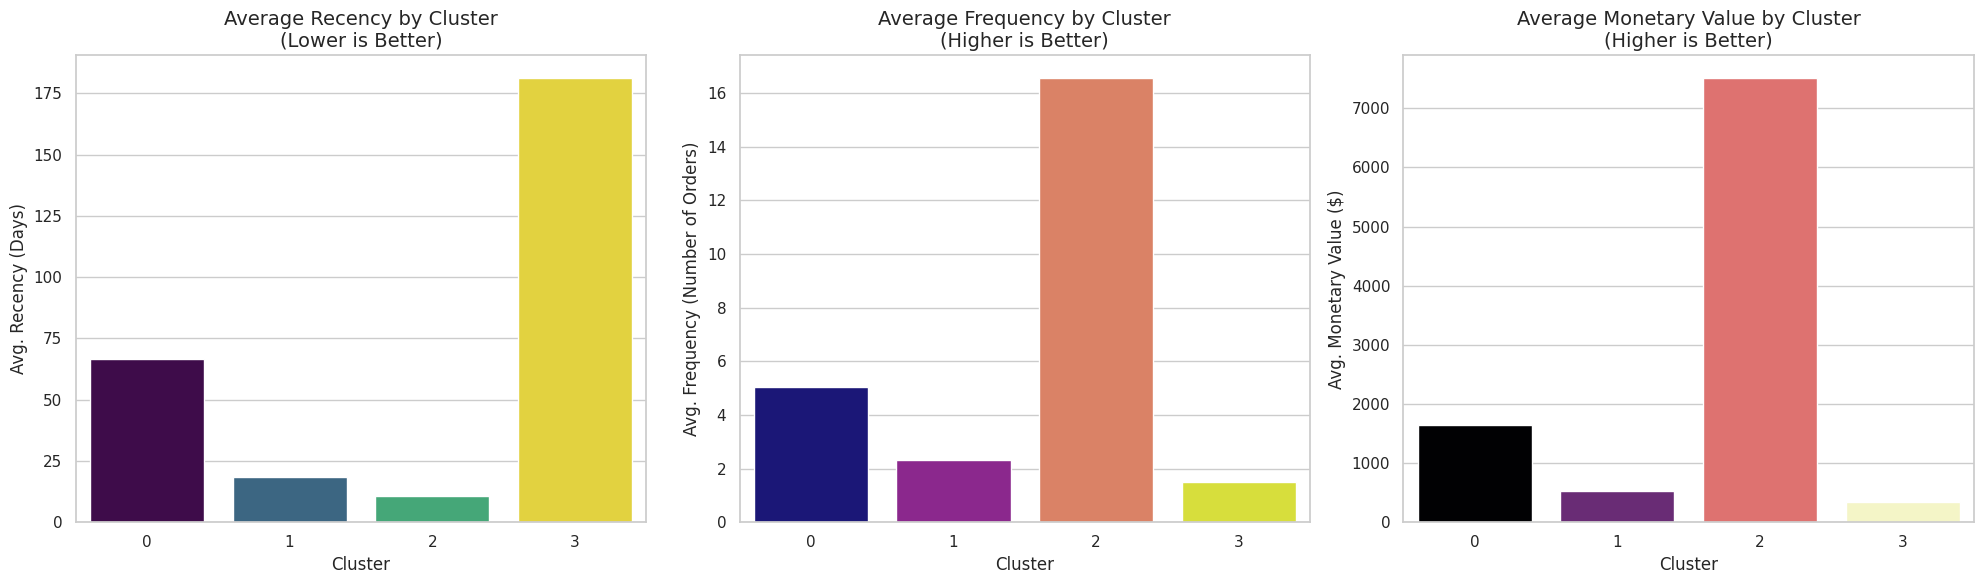

In [ ]:
# Calculate the average RFM values and customer count for each cluster
cluster_analysis = rfm_df.groupby('Cluster').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean',
    'CustomerID': 'count'
}).round(2)

cluster_analysis.rename(columns={'CustomerID': 'Customer_Count'}, inplace=True)
cluster_analysis.columns = ['Avg_Recency', 'Avg_Frequency', 'Avg_Monetary', 'Customer_Count']
print("\nCluster Analysis Summary:")
print(cluster_analysis)

# Create 3 separate bar charts for R, F, and M to compare clusters
plt.figure(figsize=(20, 6)) # Increase figure size for three plots

# Plot 1: Recency
plt.subplot(1, 3, 1)
sns.barplot(x=cluster_analysis.index, y=cluster_analysis['Avg_Recency'],
            hue=cluster_analysis.index, palette='viridis', legend=False) # Fix for warning
plt.title('Average Recency by Cluster\n(Lower is Better)', fontsize=14)
plt.xlabel('Cluster', fontsize=12)
plt.ylabel('Avg. Recency (Days)', fontsize=12)

# Plot 2: Frequency
plt.subplot(1, 3, 2)
sns.barplot(x=cluster_analysis.index, y=cluster_analysis['Avg_Frequency'],
            hue=cluster_analysis.index, palette='plasma', legend=False) # Fix for warning
plt.title('Average Frequency by Cluster\n(Higher is Better)', fontsize=14)
plt.xlabel('Cluster', fontsize=12)
plt.ylabel('Avg. Frequency (Number of Orders)', fontsize=12)

# Plot 3: Monetary
plt.subplot(1, 3, 3)
sns.barplot(x=cluster_analysis.index, y=cluster_analysis['Avg_Monetary'],
            hue=cluster_analysis.index, palette='magma', legend=False) # Fix for warning
plt.title('Average Monetary Value by Cluster\n(Higher is Better)', fontsize=14)
plt.xlabel('Cluster', fontsize=12)
plt.ylabel('Avg. Monetary Value ($)', fontsize=12)

plt.tight_layout() # Automatically adjust subplot params for a tight layout
plt.show()

##Interpreting the Clusters - Unveiling Customer Personas

With K-Means creating four distinct groups, we can now analyze the average RFM values for each to understand their unique characteristics and assign them actionable personas.

(Here I assume the cluster numbers from your second graph. If the numbers are different in your notebook, just swap them accordingly.)

Cluster Personas:

The analysis reveals a rich mosaic of four customer personas, moving far beyond a simple "good vs. bad" split.

**Cluster 2:** "The Champions" (Top-Tier, High-Value Customers)

**Low Recency (~20 days):** They have purchased very recently and are highly engaged.

**High Frequency (~16 orders):** They are our most frequent buyers.

**High Monetary Value (~$7,500):** They contribute the most significant portion of revenue.

**Persona:** These are the bedrock of the business. They are loyal, high-spending advocates who should be treated like VIPs.



**Cluster 0:** "Loyal Customers" (Consistent, High-Potential Customers)

**Medium Recency (~65 days):** They purchase regularly but not as recently as Champions.

**Medium-High Frequency (~5 orders):** They are consistent repeat customers.

**High Monetary Value (~$3,500):** Their spending is substantial.

**Persona:** This is a high-value group that forms the core of our loyal customer base. They have the potential to become Champions with the right incentives.

**Cluster 1:** "New & Promising" (Recent, Low-Frequency Customers)

**Very Low Recency (~20 days):** A key insight—they are very recent buyers!

**Low Frequency (~2 orders):** They have only made one or two purchases.

**Medium-Low Monetary Value (~$1,000):** Their spending is moderate, which is expected for new customers.

Persona: This group likely consists of new customers and recent shoppers. They are highly engaged right now, and this is a critical window to convert them into loyal customers.

**Cluster 3: "At-Risk / Lapsed"** (Infrequent, Dormant Customers)

**Very High Recency (~180 days):** They have not made a purchase in a long time.

**Very Low Frequency (~1.5 orders):** They are one-time or infrequent buyers.

**Very Low Monetary Value (~$800):** Their lifetime spending is the lowest.

**Persona:** This group is dormant and at high risk of churning permanently. They require a specific re-engagement strategy to be won back.

##**Strategic Recommendations & Conclusion**

This granular four-cluster segmentation provides a clear, multi-faceted roadmap for targeted business actions.
Recommendations for Cluster 2 (The Champions):

**Goal: Retain, Reward, and Leverage.**

**Actions:**

Implement a VIP program with exclusive benefits (e.g., free shipping, early access).

Personalize communications to thank them for their loyalty.

Engage them for testimonials, product reviews, and feedback.

Use them as a lookalike audience for new customer acquisition.



**Recommendations for Cluster 0 (Loyal Customers):**

**Goal: Increase Frequency and Upsell.**

**Actions:**

Offer subscription models or bundle deals to encourage more frequent purchasing.

Use targeted cross-sell and upsell recommendations based on their purchase history.

Provide loyalty points or time-sensitive offers to shorten the time between purchases.

**Recommendations for Cluster 1 (New & Promising):**

**Goal:** Nurture and Convert to Loyal.

**Actions:**

Launch an onboarding email sequence after their first purchase with tips and product info.

Offer a compelling discount on their second purchase to build a habit.

Engage them with content marketing that showcases the brand's value beyond just products.

**Recommendations for Cluster 3 (At-Risk / Lapsed):**

**Goal: Re-engage and Win Back.**

**Actions:**

Launch targeted "we miss you" campaigns with a significant, time-limited discount.

Conduct surveys to understand why they stopped purchasing.

Showcase new products or "what's changed since you've been gone" to reignite interest.

**Conclusion**

By applying data cleaning, metric calculation, and advanced K-Means clustering, we have successfully transformed a massive dataset into a sophisticated, four-segment customer model. We have moved beyond a simple binary view to identify distinct personas: our invaluable Champions, our consistent Loyal Customers, the high-potential New & Promising group, and the dormant At-Risk segment.

This data-driven insight allows the business to craft precise, tailored marketing strategies for each group. This approach will maximize marketing ROI by fostering loyalty among top tiers, converting new customers more effectively, and strategically re-engaging those who have lapsed—ultimately driving more sustainable and profitable growth.

In [ ]:
rfm_df.to_csv('/content/drive/MyDrive/Data for GC/Customer Analysis/Project RFM and Cluster Analysis/rfm_df.csv')

In [ ]:
df_clean.to_csv('/content/drive/MyDrive/Data for GC/Customer Analysis/Project RFM and Cluster Analysis/df_clean.csv')